# Overview
The stock market is a focus for investors to maximize their potential profits and consequently, the interest shown from the technical and financial sides in stock market prediction is always on the rise.

However, stock market prediction is a problem known for its challenging nature due to its dependency on diverse factors that affect the market, these factors are unpredictable and cannot be taken into consideration such as political variables, and social media effects such as twitter on the stock market.<br>
**Link for github repo for this project** [Github repo](https://github.com/KerolosAtef/Stock-market-prediction-using-sentiment-analysis-of-twitter)

# Import important libraries

In [1]:
import numpy as np
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import LSTM,Conv1D,Conv2D,MaxPooling2D,MaxPooling1D,Flatten
from keras.layers import Dense, Dropout
import pandas as pd
# from keras.optimizers import Adam
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import seaborn as sns
#from datetime import datetime

from tensorflow.compat.v1.keras.layers import CuDNNLSTM,Bidirectional
seed=42

# Load the dataset

In [2]:
#Read the csv file
df = pd.read_csv('../input/netflex-stock-dataset-with-twitter-sentiment/Final_nflx_data_2018-2022.csv')
df['date'] = pd.to_datetime(df['date'])
df

,date,Open,High,Low,Close,Adj Close,Volume,P_mean,P_sum,twt_count
0,2018-01-02,196.100006,201.649994,195.419998,201.070007,201.070007,10966900,0.020833,10,480
1,2018-01-03,202.050003,206.210007,201.500000,205.050003,205.050003,8591400,0.071217,24,337
2,2018-01-04,206.199997,207.050003,204.000000,205.630005,205.630005,6029600,-0.018519,-4,216
3,2018-01-05,207.250000,210.020004,205.589996,209.990005,209.990005,7033200,-0.019737,-6,304
4,2018-01-08,210.020004,212.500000,208.440002,212.050003,212.050003,5580200,-0.007663,-2,261
...,...,...,...,...,...,...,...,...,...,...
1132,2022-07-01,176.490005,180.100006,174.270004,179.949997,179.949997,5194700,-0.062315,-21,337
1133,2022-07-05,176.279999,185.919998,172.679993,185.880005,185.880005,7334300,-0.058824,-25,425
1134,2022-07-06,185.199997,186.220001,180.820007,184.059998,184.059998,5753400,-0.014870,-8,538
1135,2022-07-07,184.270004,190.210007,183.500000,189.270004,189.270004,6334500,-0.055427,-24,433


## Understanding the time Series

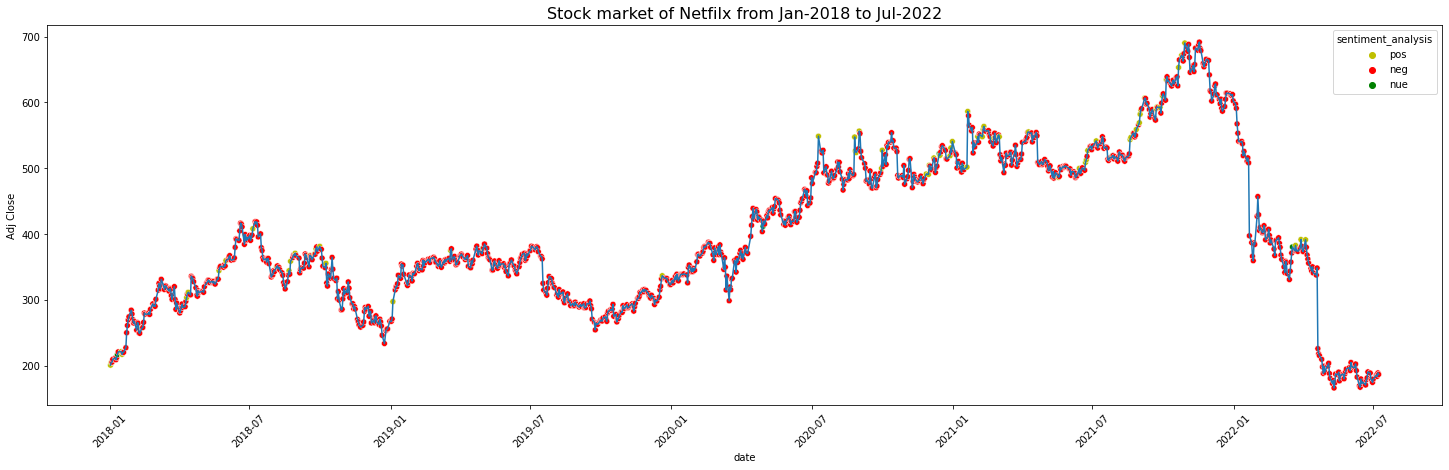

In [3]:
import seaborn as sns
plt.figure(figsize=(25,7));
sns.lineplot(x=df["date"],y=df["Adj Close"])
df['sentiment_analysis']=df['P_mean']
df['sentiment_analysis']=df['sentiment_analysis'].apply(lambda x: 'pos' if x>0 else 'nue' if x==0 else 'neg')
sns.scatterplot(x=df["date"],y=df['Adj Close'],hue=df['sentiment_analysis'],palette=['y','r','g'])
plt.xticks(rotation=45);
plt.title("Stock market of Netfilx from Jan-2018 to Jul-2022",fontsize=16);

In [4]:
df['sentiment_analysis'].value_counts()

neg    1059
pos      71
nue       7
Name: sentiment_analysis, dtype: int64

In [5]:
df=df.drop(list(range(14)),axis=0,inplace=False)
df

,date,Open,High,Low,Close,Adj Close,Volume,P_mean,P_sum,twt_count,sentiment_analysis
14,2018-01-23,255.050003,257.709991,248.020004,250.289993,250.289993,27705300,-0.061196,-88,1438,neg
15,2018-01-24,250.880005,261.709991,249.309998,261.299988,261.299988,17352400,-0.084525,-65,769,neg
16,2018-01-25,263.000000,272.299988,260.230011,269.700012,269.700012,15336400,-0.122744,-102,831,neg
17,2018-01-26,271.489990,274.600006,268.760010,274.600006,274.600006,11021800,-0.118012,-57,483,neg
18,2018-01-29,274.200012,286.809998,273.920013,284.589996,284.589996,17529700,-0.100690,-73,725,neg
...,...,...,...,...,...,...,...,...,...,...,...
1132,2022-07-01,176.490005,180.100006,174.270004,179.949997,179.949997,5194700,-0.062315,-21,337,neg
1133,2022-07-05,176.279999,185.919998,172.679993,185.880005,185.880005,7334300,-0.058824,-25,425,neg
1134,2022-07-06,185.199997,186.220001,180.820007,184.059998,184.059998,5753400,-0.014870,-8,538,neg
1135,2022-07-07,184.270004,190.210007,183.500000,189.270004,189.270004,6334500,-0.055427,-24,433,neg


In [6]:
train_dates = pd.to_datetime(df['date'])
# print(train_dates.tail(15)) #Check last few dates.

#Variables for training
cols = [
    'Open',
    'High', 'Low',
    'Close',
    'Volume',
    'Adj Close',
    'P_mean',
        ]
#Date and volume columns are not used in training.
print(cols)

#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)
df_for_training.index=df['date']
df_for_training

['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'P_mean']


,Open,High,Low,Close,Volume,Adj Close,P_mean
date,,,,,,,
2018-01-23,255.050003,257.709991,248.020004,250.289993,27705300.0,250.289993,-0.061196
2018-01-24,250.880005,261.709991,249.309998,261.299988,17352400.0,261.299988,-0.084525
2018-01-25,263.000000,272.299988,260.230011,269.700012,15336400.0,269.700012,-0.122744
2018-01-26,271.489990,274.600006,268.760010,274.600006,11021800.0,274.600006,-0.118012
2018-01-29,274.200012,286.809998,273.920013,284.589996,17529700.0,284.589996,-0.100690
...,...,...,...,...,...,...,...
2022-07-01,176.490005,180.100006,174.270004,179.949997,5194700.0,179.949997,-0.062315
2022-07-05,176.279999,185.919998,172.679993,185.880005,7334300.0,185.880005,-0.058824
2022-07-06,185.199997,186.220001,180.820007,184.059998,5753400.0,184.059998,-0.014870


# LSTM Model

## Data scaling for LSTM because uses sigmoid and tanh that are sensitive to magnitude

In [7]:
scaler = MinMaxScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

scaler_for_inference = MinMaxScaler()
scaler_for_inference.fit_transform(df_for_training.loc[:,['Open','Adj Close']])

df_for_training_scaled
# df_for_training_scaled=df_for_training.copy()
# df_for_training_scaled=df_for_training_scaled.to_numpy()

array([[0.17239161, 0.16193068, 0.16299819, ..., 0.20085146, 0.15975024,
        0.58996553],
       [0.16449971, 0.16949312, 0.16546293, ..., 0.12256481, 0.18070889,
        0.52005358],
       [0.18743731, 0.18951466, 0.18632733, ..., 0.10732021, 0.19669918,
        0.40552279],
       ...,
       [0.04019756, 0.02677103, 0.03460201, ..., 0.0348554 , 0.03367472,
        0.72879365],
       [0.03843751, 0.03431458, 0.03972256, ..., 0.03924957, 0.04359249,
        0.60725335],
       [0.04174946, 0.03374739, 0.03828956, ..., 0.03544446, 0.03923323,
        0.6444625 ]])

## As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features.

In [8]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 5  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future,[0,-2]])

trainX, trainY = np.array(trainX), np.array(trainY)

print('TrainX shape = {}.'.format(trainX.shape))
print('TrainY shape = {}.'.format(trainY.shape))

TrainX shape = (1118, 5, 7).
TrainY shape = (1118, 1, 2).


## Train test split for LSTM

In [9]:
from sklearn.model_selection import train_test_split

X_train_lstm_without_twitter, X_test_lstm_without_twitter, y_train_lstm_without_twitter, y_test_lstm_without_twitter = train_test_split(trainX[:,:,:-1], trainY, test_size=0.2, shuffle=False)

X_train_lstm_twitter, X_test_lstm_twitter, y_train_lstm_twitter, y_test_lstm_twitter = train_test_split(trainX, trainY, test_size=0.2, shuffle=False)

X_train_lstm_without_twitter.shape,X_train_lstm_twitter.shape

((894, 5, 6), (894, 5, 7))

## Train validation split for LSTM

In [10]:
from sklearn.model_selection import train_test_split

X_train_lstm_without_twitter, X_val_lstm_without_twitter, y_train_lstm_without_twitter, y_val_lstm_without_twitter = train_test_split(X_train_lstm_without_twitter, y_train_lstm_without_twitter, test_size=0.1, shuffle=False)

X_train_lstm_twitter, X_val_lstm_twitter, y_train_lstm_twitter, y_val_lstm_twitter = train_test_split(X_train_lstm_twitter, y_train_lstm_twitter, test_size=0.1, shuffle=False)

X_train_lstm_without_twitter.shape,X_train_lstm_twitter.shape

((804, 5, 6), (804, 5, 7))

## Model architecture

In [11]:
def build_model(input_shape):
    tf.random.set_seed(seed)
    cnn_lstm_model = Sequential()

    cnn_lstm_model.add(Conv1D(filters=128, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    cnn_lstm_model.add(MaxPooling1D(pool_size=2, strides=2))

    cnn_lstm_model.add(Conv1D(filters=64, kernel_size=2, strides=1, padding='valid'))
    cnn_lstm_model.add(MaxPooling1D(pool_size=1, strides=2))
    # cnn_lstm_model.add(MaxPooling1D(pool_size=1, strides=2))

    cnn_lstm_model.add(Bidirectional(CuDNNLSTM(256, return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))
    cnn_lstm_model.add(Bidirectional(CuDNNLSTM(256, return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))

    cnn_lstm_model.add(Dense(32, activation='relu'))


    cnn_lstm_model.add(Dense(trainY.shape[2], activation='relu'))

    # cnn_lstm_model.build(input_shape=(trainX.shape[0], trainX.shape[1], trainX.shape[2]))

    cnn_lstm_model.compile(optimizer='adam', loss='mse')
    cnn_lstm_model.summary()
    return cnn_lstm_model

In [12]:
# fit the model

cnn_lstm_model_without_twitter=build_model((X_train_lstm_without_twitter.shape[1],X_train_lstm_without_twitter.shape[2]))
cnn_lstm_model_twitter=build_model((X_train_lstm_twitter.shape[1],X_train_lstm_twitter.shape[2]))

history_without_twitter = cnn_lstm_model_without_twitter.fit(X_train_lstm_without_twitter, y_train_lstm_without_twitter, epochs=50, batch_size=64, validation_data=(X_val_lstm_without_twitter, y_val_lstm_without_twitter), verbose=1, )


history_twitter = cnn_lstm_model_twitter.fit(X_train_lstm_twitter, y_train_lstm_twitter, epochs=50, batch_size=64, validation_data=(X_val_lstm_twitter, y_val_lstm_twitter), verbose=1, )

2022-08-24 21:41:53.205433: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-24 21:41:53.339488: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-24 21:41:53.340320: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-24 21:41:53.342367: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 4, 128)            1664      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2, 128)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 64)             16448     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 64)             0         
_________________________________________________________________
bidirectional (Bidirectional (None, 1, 512)            659456    
_________________________________________________________________
dropout (Dropout)            (None, 1, 512)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1, 512)            1

2022-08-24 21:41:57.211093: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-08-24 21:42:01.009949: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


13/13 [==============================] - 11s 86ms/step - loss: 0.0681 - val_loss: 0.0608
Epoch 2/50
13/13 [==============================] - 0s 8ms/step - loss: 0.0109 - val_loss: 0.0042
Epoch 3/50
13/13 [==============================] - 0s 8ms/step - loss: 0.0045 - val_loss: 6.1504e-04
Epoch 4/50
13/13 [==============================] - 0s 9ms/step - loss: 0.0027 - val_loss: 5.3210e-04
Epoch 5/50
13/13 [==============================] - 0s 8ms/step - loss: 0.0014 - val_loss: 6.8977e-04
Epoch 6/50
13/13 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 3.3844e-04
Epoch 7/50
13/13 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 4.4411e-04
Epoch 8/50
13/13 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 3.3774e-04
Epoch 9/50
13/13 [==============================] - 0s 10ms/step - loss: 0.0011 - val_loss: 3.9500e-04
Epoch 10/50
13/13 [==============================] - 0s 10ms/step - loss: 0.0011 - val_loss: 3.376

## Plotting Training and validation loss

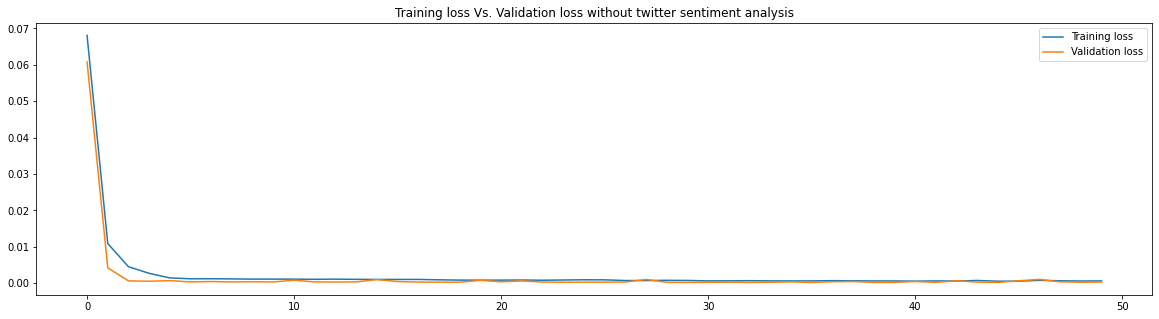

In [13]:
plt.figure(figsize=(20,5))
plt.plot(history_without_twitter.history['loss'], label='Training loss')
plt.plot(history_without_twitter.history['val_loss'], label='Validation loss')
plt.title('Training loss Vs. Validation loss without twitter sentiment analysis')
plt.legend()


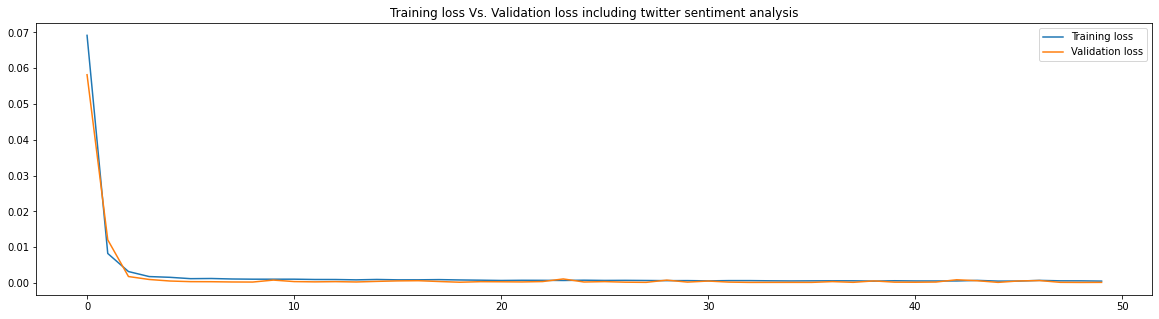

In [14]:
plt.figure(figsize=(20,5))
plt.plot(history_twitter.history['loss'], label='Training loss')
plt.plot(history_twitter.history['val_loss'], label='Validation loss')
plt.title('Training loss Vs. Validation loss including twitter sentiment analysis')
plt.legend()

## Plotting

In [15]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
from math import sqrt

def plot_predictions_with_dates (type,twitter,dates,y_actual_lstm,y_pred_lstm):
    predicted_features=['Open','Adj Close']
    for i,predicted_feature in enumerate(predicted_features):
        plt.figure(figsize=(15,6))
        if twitter :
            plt.title(f'LSTM {type} prediction of {predicted_feature} feature After adding twitter sentiment analysis')
        else:
            plt.title(f'LSTM {type} prediction of {predicted_feature} feature without twitter sentiment analysis')
        sns.lineplot(x=dates, y=y_actual_lstm[:,i],label='Actual')
        sns.lineplot(x=dates, y=y_pred_lstm[:, i], label='Predicted')
        plt.show()
        error=mean_squared_error(y_actual_lstm[:,i], y_pred_lstm[:, i])
        print(f'Mean square error for {predicted_feature} ={error}')
    print('Total mean square error', mean_squared_error(y_actual_lstm, y_pred_lstm))

# Computing training accuracy

In [16]:
training_dates= df_for_training.index[:X_train_lstm_without_twitter.shape[0]]
#Make prediction
training_prediction_without_twitter = cnn_lstm_model_without_twitter.predict(X_train_lstm_without_twitter)

training_prediction_twitter = cnn_lstm_model_twitter.predict(X_train_lstm_twitter)

training_prediction_without_twitter=training_prediction_without_twitter.reshape(training_prediction_without_twitter.shape[0], training_prediction_without_twitter.shape[2])

training_prediction_twitter=training_prediction_twitter.reshape(training_prediction_twitter.shape[0], training_prediction_twitter.shape[2])

y_train_pred_lstm_without_twitter = scaler_for_inference.inverse_transform(training_prediction_without_twitter)

y_train_pred_lstm_twitter = scaler_for_inference.inverse_transform(training_prediction_twitter)

y_train_lstm_reshaped_without_twitter=y_train_lstm_without_twitter.reshape(y_train_lstm_without_twitter.shape[0], y_train_lstm_without_twitter.shape[2])

y_train_actual_lstm = scaler_for_inference.inverse_transform(y_train_lstm_reshaped_without_twitter)



####  Training accuracy without twitter

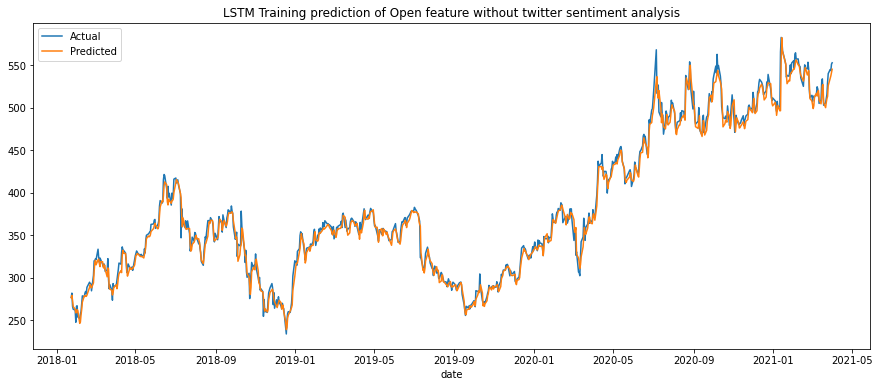

Mean square error for Open =68.44163552711531


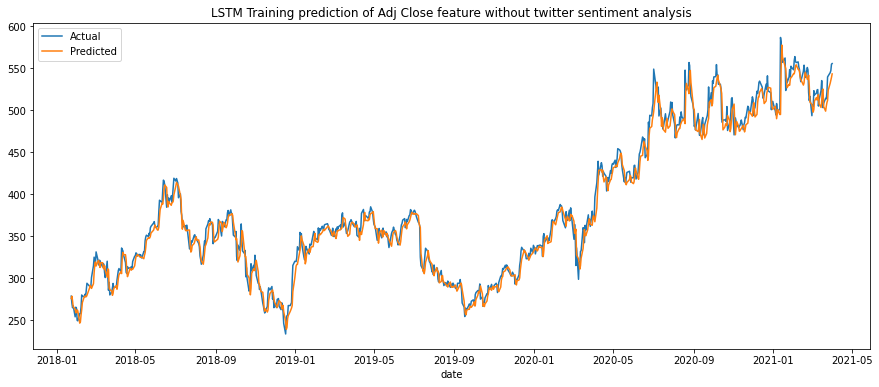

Mean square error for Adj Close =137.52857924514487
Total mean square error 102.98510738613004


In [17]:
plot_predictions_with_dates('Training',False,training_dates,y_train_actual_lstm,y_train_pred_lstm_without_twitter)

#### Training accuracy after adding the impact of twitter sentiment analysis

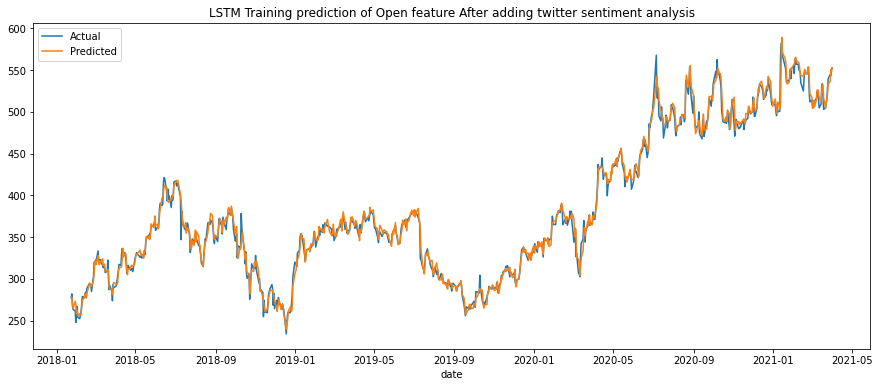

Mean square error for Open =56.08447027472627


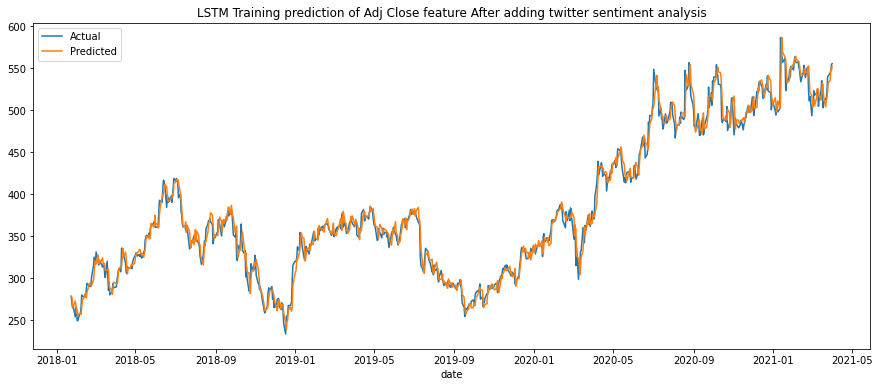

Mean square error for Adj Close =115.07709436603064
Total mean square error 85.5807823203784


In [18]:
plot_predictions_with_dates('Training',True,training_dates,y_train_actual_lstm,y_train_pred_lstm_twitter)

## Computing validation accuracy

In [19]:
validation_dates= df_for_training.index[X_train_lstm_without_twitter.shape[0]:X_train_lstm_without_twitter.shape[0] + X_val_lstm_without_twitter.shape[0]]
#Make prediction
validation_prediction_without_twitter = cnn_lstm_model_without_twitter.predict(X_val_lstm_without_twitter)

validation_prediction_twitter = cnn_lstm_model_twitter.predict(X_val_lstm_twitter)

validation_prediction_without_twitter=validation_prediction_without_twitter.reshape(validation_prediction_without_twitter.shape[0], validation_prediction_without_twitter.shape[2])


validation_prediction_twitter=validation_prediction_twitter.reshape(validation_prediction_twitter.shape[0], validation_prediction_twitter.shape[2])


y_val_pred_lstm_without_twitter = scaler_for_inference.inverse_transform(validation_prediction_without_twitter)
y_val_pred_lstm_twitter = scaler_for_inference.inverse_transform(validation_prediction_twitter)

y_val_actual_lstm_reshaped_without_twitter=y_val_lstm_without_twitter.reshape(y_val_lstm_without_twitter.shape[0], y_val_lstm_without_twitter.shape[2])

y_val_actual_lstm = scaler_for_inference.inverse_transform(y_val_actual_lstm_reshaped_without_twitter)



#### Validation accuracy without twitter

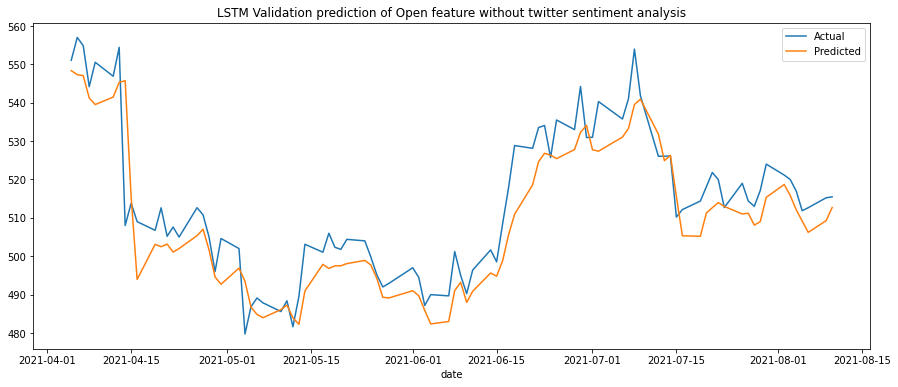

Mean square error for Open =64.06486957722032


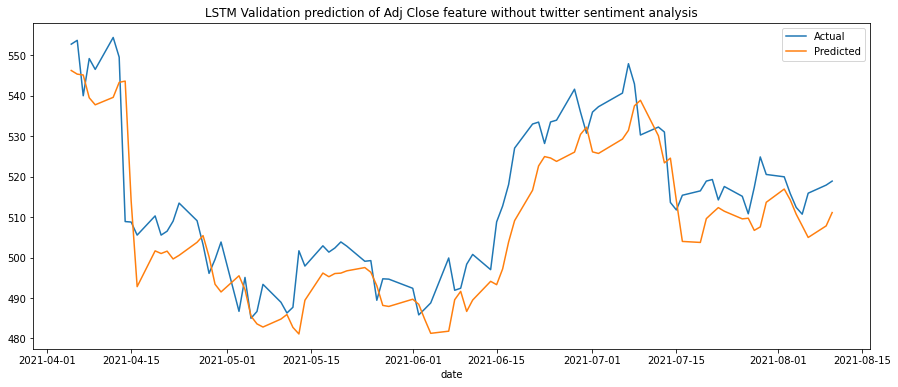

Mean square error for Adj Close =93.44627530486565
Total mean square error 78.75557244104299


In [20]:
plot_predictions_with_dates('Validation',False,validation_dates,y_val_actual_lstm,y_val_pred_lstm_without_twitter)

#### Validation accuracy after adding the impact of twitter sentiment analysis

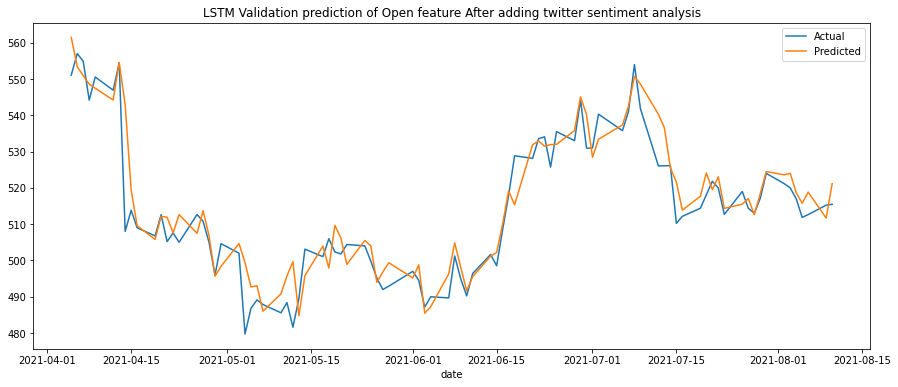

Mean square error for Open =44.807976379640984


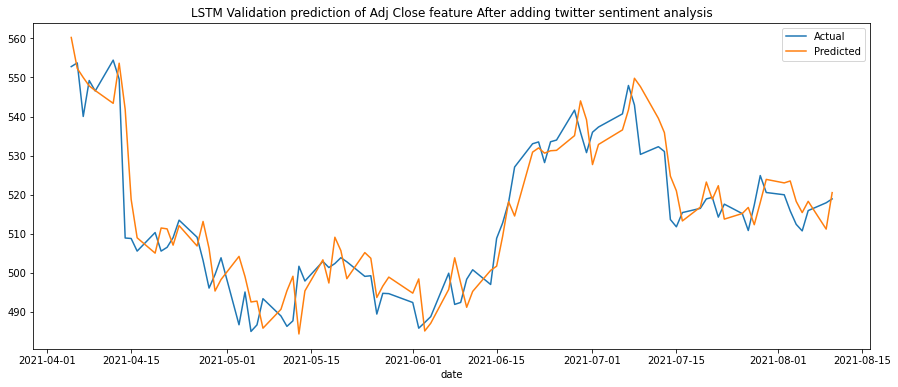

Mean square error for Adj Close =56.333907839947
Total mean square error 50.57094210979399


In [21]:
plot_predictions_with_dates('Validation',True,validation_dates,y_val_actual_lstm,y_val_pred_lstm_twitter)

## Computing testing accuracy

In [22]:
testing_dates= df_for_training.index[-X_test_lstm_without_twitter.shape[0]:]
#Make prediction
testing_prediction_without_twitter = cnn_lstm_model_without_twitter.predict(X_test_lstm_without_twitter)
testing_prediction_twitter = cnn_lstm_model_twitter.predict(X_test_lstm_twitter)

testing_prediction_without_twitter=testing_prediction_without_twitter.reshape(testing_prediction_without_twitter.shape[0], testing_prediction_without_twitter.shape[2])
testing_prediction_twitter=testing_prediction_twitter.reshape(testing_prediction_twitter.shape[0], testing_prediction_twitter.shape[2])

y_test_pred_lstm_without_twitter = scaler_for_inference.inverse_transform(testing_prediction_without_twitter)
y_test_pred_lstm_twitter = scaler_for_inference.inverse_transform(testing_prediction_twitter)

y_test_actual_lstm_reshaped_without_twitter=y_test_lstm_without_twitter.reshape(y_test_lstm_without_twitter.shape[0], y_test_lstm_without_twitter.shape[2])


y_test_actual_lstm = scaler_for_inference.inverse_transform(y_test_actual_lstm_reshaped_without_twitter)



#### Testing accuracy without twitter

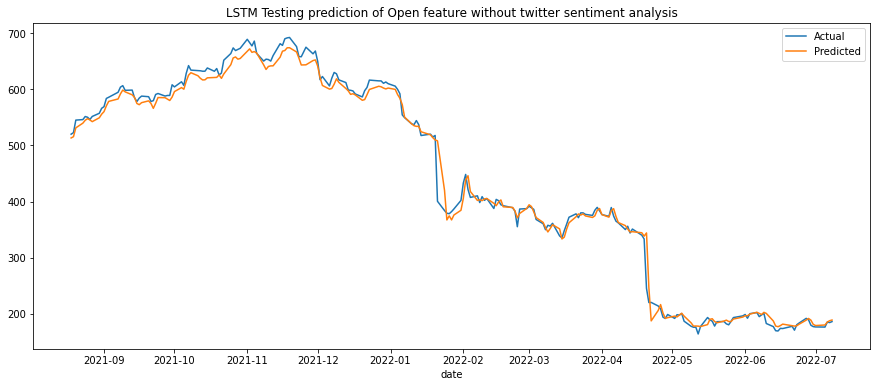

Mean square error for Open =209.08995790671202


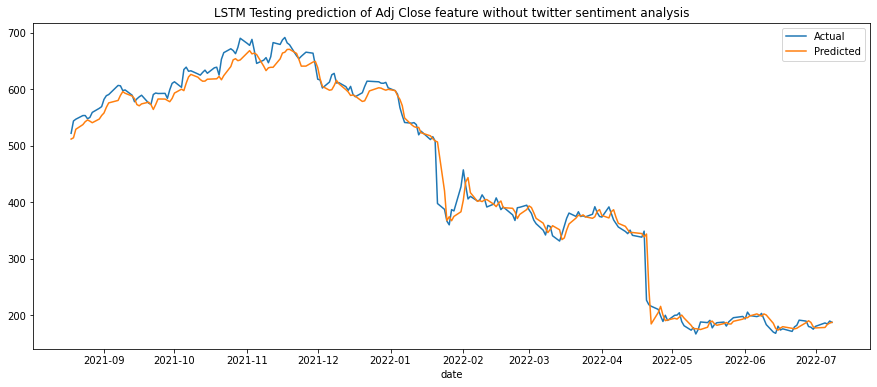

Mean square error for Adj Close =344.0692344534592
Total mean square error 276.5795961800855


In [23]:
plot_predictions_with_dates('Testing',False,testing_dates,y_test_actual_lstm,y_test_pred_lstm_without_twitter)

#### Testing accuracy after adding the impact of twitter sentiment analysis

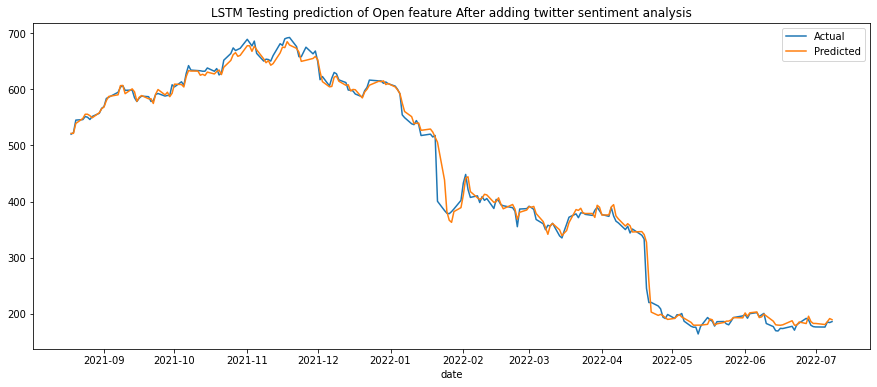

Mean square error for Open =159.77003597310528


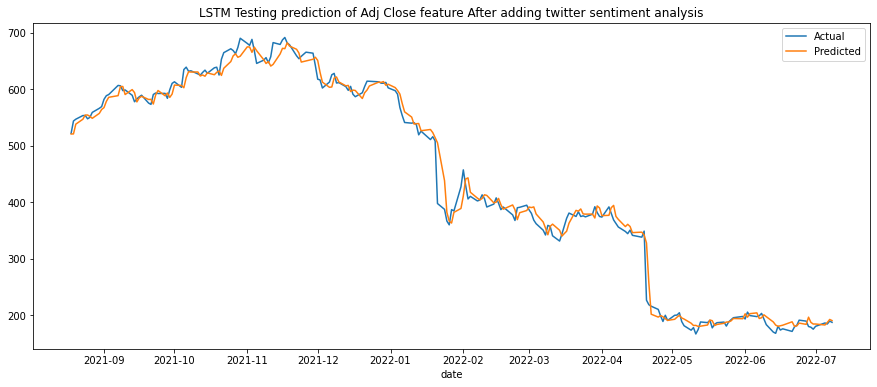

Mean square error for Adj Close =280.7224150829578
Total mean square error 220.24622552803152


In [24]:
plot_predictions_with_dates('Testing',True,testing_dates,y_test_actual_lstm,y_test_pred_lstm_twitter)

# ARIMA

In [25]:
!pip install pmdarima==1.8.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.5 MB/s eta 0:00:00


## Train test split for Arima

In [26]:
df_arima=df_for_training.copy()
# df_arima['Volume']=df['Volume']
n_past_for_arima=1
adj_close_feature=df_arima['Adj Close']
open_feature=df_arima['Open']
df_arima['Adj Close']=df_arima['Adj Close'].shift(-n_past_for_arima)
df_arima['Open']=df_arima['Open'].shift(-n_past_for_arima)
df_arima.dropna(inplace=True)
df_arima['Adj Close_feature']=adj_close_feature.iloc[:-1]
df_arima['open_feature_feature']=open_feature.iloc[:-1]
# df_arima=df_arima.reindex(columns=['open_lag','High', 'Low', 'Close', 'adj_close_lag','P_mean','Adj Close','Open',])
X_arima=df_arima.drop(['Adj Close','Open'],axis=1)
y_arima=df_arima[['Open','Adj Close']]
X_train_arima_twitter, X_test_arima_twitter, y_train_arima, y_test_arima=train_test_split(X_arima, y_arima, test_size=0.2, shuffle=False)

X_train_arima_without_twitter, X_test_arima_without_twitter= X_train_arima_twitter.drop('P_mean', axis=1), X_test_arima_twitter.drop('P_mean', axis=1)
X_train_arima_without_twitter


,High,Low,Close,Volume,Adj Close_feature,open_feature_feature
date,,,,,,
2018-01-23,257.709991,248.020004,250.289993,27705300.0,261.299988,250.880005
2018-01-24,261.709991,249.309998,261.299988,17352400.0,269.700012,263.000000
2018-01-25,272.299988,260.230011,269.700012,15336400.0,274.600006,271.489990
2018-01-26,274.600006,268.760010,274.600006,11021800.0,284.589996,274.200012
2018-01-29,286.809998,273.920013,284.589996,17529700.0,278.799988,277.000000
...,...,...,...,...,...,...
2021-08-09,522.669983,517.989990,519.969971,1367800.0,515.840027,520.000000
2021-08-10,520.789978,512.969971,515.840027,1960500.0,512.400024,517.000000
2021-08-11,519.570007,509.769989,512.400024,1673900.0,510.720001,511.859985


In [27]:
X_train_arima_twitter

,High,Low,Close,Volume,P_mean,Adj Close_feature,open_feature_feature
date,,,,,,,
2018-01-23,257.709991,248.020004,250.289993,27705300.0,-0.061196,261.299988,250.880005
2018-01-24,261.709991,249.309998,261.299988,17352400.0,-0.084525,269.700012,263.000000
2018-01-25,272.299988,260.230011,269.700012,15336400.0,-0.122744,274.600006,271.489990
2018-01-26,274.600006,268.760010,274.600006,11021800.0,-0.118012,284.589996,274.200012
2018-01-29,286.809998,273.920013,284.589996,17529700.0,-0.100690,278.799988,277.000000
...,...,...,...,...,...,...,...
2021-08-09,522.669983,517.989990,519.969971,1367800.0,-0.051282,515.840027,520.000000
2021-08-10,520.789978,512.969971,515.840027,1960500.0,-0.085427,512.400024,517.000000
2021-08-11,519.570007,509.769989,512.400024,1673900.0,-0.058824,510.720001,511.859985


## Arima model to predict open prices

In [28]:
from pmdarima import auto_arima
arima_model_for_open_without_twitter = auto_arima(y_train_arima['Open'], exogenous=X_train_arima_without_twitter,
                                                  start_p=2, d=None, start_q=3, max_p=5, max_d=3, max_q=5, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5,
                                                  seasonal=True,
                                                  error_action='ignore',
                                                  suppress_warnings=True,
                                                  stepwise=True
                                                  )

arima_model_for_open_twitter = auto_arima(y_train_arima['Open'], exogenous=X_train_arima_twitter,
                                          start_p=2, d=None, start_q=3, max_p=5, max_d=3, max_q=5, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5,
                                          seasonal=True,
                                          error_action='ignore',
                                          suppress_warnings=True,
                                          stepwise=True
                                          )
arima_model_for_open_without_twitter.summary()
arima_model_for_open_twitter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  897
Model:               SARIMAX(0, 1, 0)   Log Likelihood                9481.618
Date:                Wed, 24 Aug 2022   AIC                         -18947.237
Time:                        21:43:03   BIC                         -18908.853
Sample:                             0   HQIC                        -18932.571
                                - 897                                         
Covariance Type:                  opg                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
High                 -7.286e-16      0.000   -2.5e-12      1.000      -0.001       0.001
Low                     1.2e-15      0.001    9.7e-13      1.000      -0.002       0.002
Close                 2.776e-17      0.001   2.99e-14      1.000      -0.002       0.002
Volume               -8.703e-17   9.49e-10  -9.17e-08      1.000   -1.86e-09    1.86e-09
P_mean                 2.17e-14   1.58e-06   1.38e-08      1.000   -3.09e-06    3.09e-06
Adj Close_feature     1.336e-16      0.001   1.74e-13      1.000      -0.002       0.002
open_feature_feature     1.0000      0.001   1411.750      0.000       0.999       1.001
sigma2                    1e-10   6.81e-11      1.468      0.142   -3.35e-11    2.34e-10
===================================================================================
Ljung-Box (L1) (Q):                  48.88   Jarque-Bera (JB):             12453.04
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.42   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.93e+21. Standard errors may be unstable.
"""

## Computing training accuracy for open prices

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


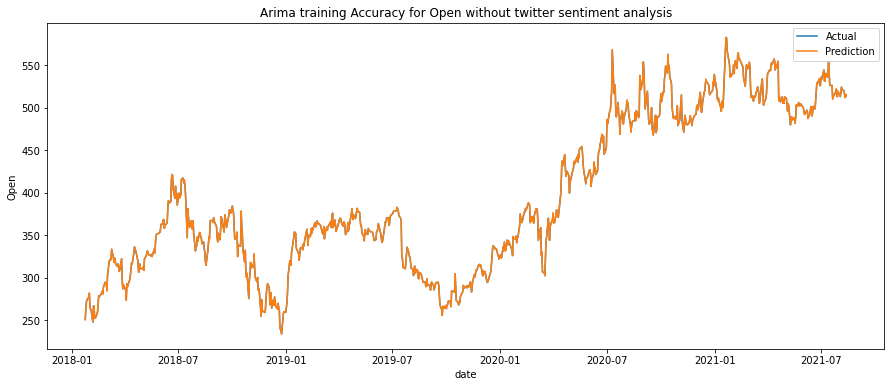

Training mean square error for open feature without twitter 1.1820287232440492e-18


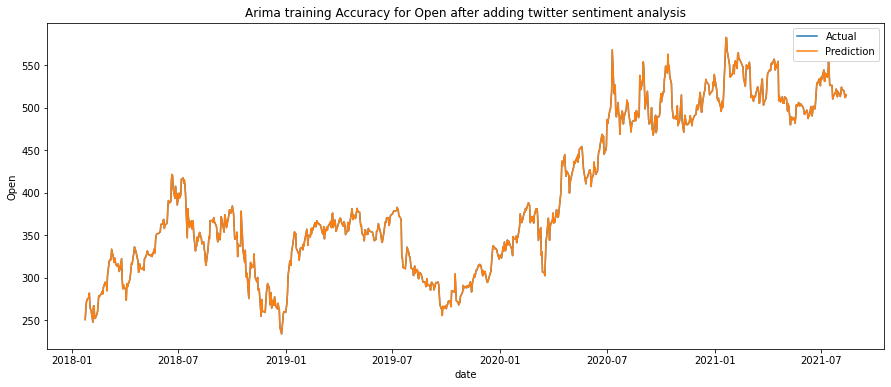

Training mean square error for open feature with twitter 4.604198572426738e-19


In [29]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
train_prediction_without_twitter= arima_model_for_open_without_twitter.predict(n_periods=len(X_train_arima_without_twitter), exogenous=X_train_arima_without_twitter)
train_prediction_twitter= arima_model_for_open_twitter.predict(n_periods=len(X_train_arima_twitter), exogenous=X_train_arima_twitter)
plt.figure(figsize=(15,6))
sns.lineplot(x=y_train_arima['Open'].index, y=y_train_arima['Open'], label='Actual')
sns.lineplot(x=y_train_arima['Open'].index, y=train_prediction_without_twitter, label='Prediction')
plt.title('Arima training Accuracy for Open without twitter sentiment analysis')
plt.show()
e=mean_squared_error(train_prediction_without_twitter, y_train_arima['Open'])
print(f'Training mean square error for open feature without twitter {e}')

plt.figure(figsize=(15,6))
sns.lineplot(x=y_train_arima['Open'].index, y=y_train_arima['Open'], label='Actual')
sns.lineplot(x=y_train_arima['Open'].index, y=train_prediction_twitter, label='Prediction')
plt.title('Arima training Accuracy for Open after adding twitter sentiment analysis')
plt.show()
e=mean_squared_error(train_prediction_twitter, y_train_arima['Open'])
print(f'Training mean square error for open feature with twitter {e}')


## Computing testing accuracy for open prices

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


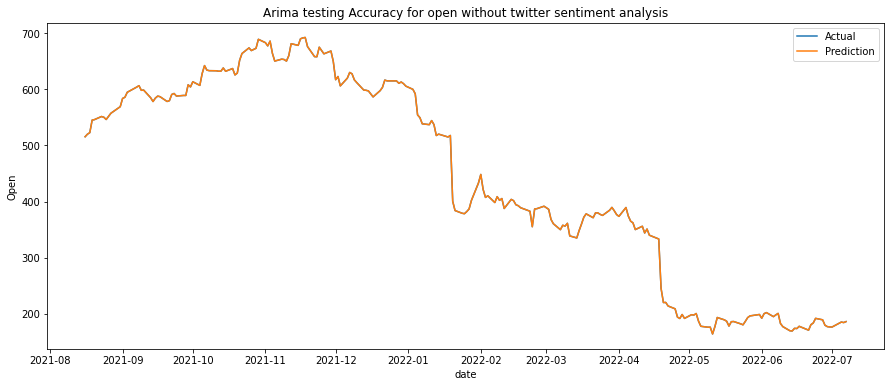

Testing mean square error for open feature without twitter sentiment analysis 2.9449940298976172e-18


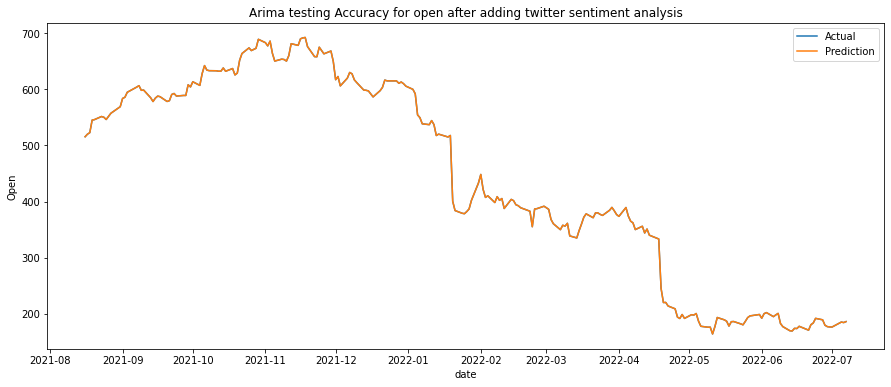

Testing mean square error for open feature with twitter sentiment analysis 1.1470825568056457e-18


In [30]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
test_prediction_without_twitter= arima_model_for_open_without_twitter.predict(n_periods=len(X_test_arima_without_twitter), exogenous=X_test_arima_without_twitter)
test_prediction_twitter= arima_model_for_open_twitter.predict(n_periods=len(X_test_arima_twitter), exogenous=X_test_arima_twitter)
plt.figure(figsize=(15,6))
sns.lineplot(x=y_test_arima['Open'].index, y=y_test_arima['Open'], label='Actual')
sns.lineplot(x=y_test_arima['Open'].index, y=test_prediction_without_twitter, label='Prediction')
plt.title('Arima testing Accuracy for open without twitter sentiment analysis')
plt.show()
e=mean_squared_error(test_prediction_without_twitter, y_test_arima['Open'])
print(f'Testing mean square error for open feature without twitter sentiment analysis {e}')

plt.figure(figsize=(15,6))
sns.lineplot(x=y_test_arima['Open'].index, y=y_test_arima['Open'], label='Actual')
sns.lineplot(x=y_test_arima['Open'].index, y=test_prediction_twitter, label='Prediction')
plt.title('Arima testing Accuracy for open after adding twitter sentiment analysis')
plt.show()
e=mean_squared_error(test_prediction_twitter, y_test_arima['Open'])
print(f'Testing mean square error for open feature with twitter sentiment analysis {e}')


## Arima model for Adjusted Close prices

In [31]:
from pmdarima import auto_arima
arima_model_for_Adj_Close_without_twitter = auto_arima(y_train_arima['Adj Close'], exogenous=X_train_arima_without_twitter,
                                                  start_p=2, d=None, start_q=3, max_p=5, max_d=3, max_q=5, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5,
                                                  seasonal=True,
                                                  error_action='ignore',
                                                  suppress_warnings=True,
                                                  stepwise=True
                                                  )

arima_model_for_Adj_Close_twitter = auto_arima(y_train_arima['Adj Close'], exogenous=X_train_arima_twitter,
                                          start_p=2, d=None, start_q=3, max_p=5, max_d=3, max_q=5, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5,
                                          seasonal=True,
                                          error_action='ignore',
                                          suppress_warnings=True,
                                          stepwise=True
                                          )
arima_model_for_Adj_Close_without_twitter.summary()
arima_model_for_Adj_Close_twitter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  897
Model:               SARIMAX(0, 1, 0)   Log Likelihood                9481.618
Date:                Wed, 24 Aug 2022   AIC                         -18947.237
Time:                        21:43:16   BIC                         -18908.853
Sample:                             0   HQIC                        -18932.571
                                - 897                                         
Covariance Type:                  opg                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
High                  4.788e-16   6.27e-16      0.764      0.445    -7.5e-16    1.71e-15
Low                  -6.939e-18   3.45e-15     -0.002      0.998   -6.77e-15    6.76e-15
Close                 -2.88e-16   3.78e-16     -0.762      0.446   -1.03e-15    4.52e-16
Volume                8.506e-18   5.26e-09   1.62e-09      1.000   -1.03e-08    1.03e-08
P_mean                4.219e-14   5.34e-20    7.9e+05      0.000    4.22e-14    4.22e-14
Adj Close_feature        1.0000   3.12e-17   3.21e+16      0.000       1.000       1.000
open_feature_feature -3.747e-16    2.4e-15     -0.156      0.876   -5.07e-15    4.32e-15
sigma2                    1e-10   6.79e-11      1.474      0.141    -3.3e-11    2.33e-10
===================================================================================
Ljung-Box (L1) (Q):                  48.85   Jarque-Bera (JB):             12430.42
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.42   Skew:                            -0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.75e+39. Standard errors may be unstable.
"""

## Computing training accuracy for Adjusted Close prices

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


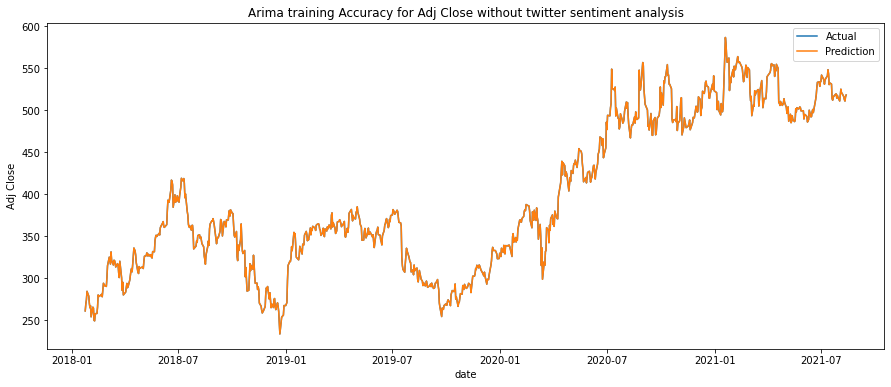

Training mean absolute error for Adj Close feature without twitter 4.076184298224677e-21


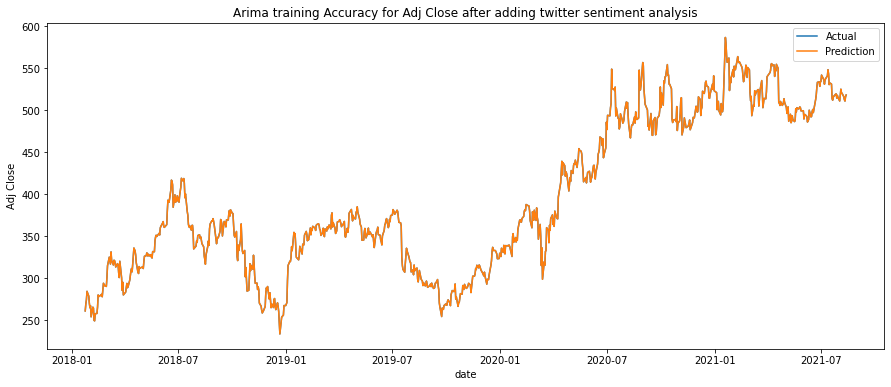

Training mean absolute error for Adj Close feature with twitter 4.387364128256565e-21


In [32]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
train_prediction_without_twitter= arima_model_for_Adj_Close_without_twitter.predict(n_periods=len(X_train_arima_without_twitter), exogenous=X_train_arima_without_twitter)
train_prediction_twitter= arima_model_for_Adj_Close_twitter.predict(n_periods=len(X_train_arima_twitter), exogenous=X_train_arima_twitter)
plt.figure(figsize=(15,6))
sns.lineplot(x=y_train_arima['Adj Close'].index, y=y_train_arima['Adj Close'], label='Actual')
sns.lineplot(x=y_train_arima['Adj Close'].index, y=train_prediction_without_twitter, label='Prediction')
plt.title('Arima training Accuracy for Adj Close without twitter sentiment analysis')
plt.show()
e=mean_squared_error(train_prediction_without_twitter, y_train_arima['Adj Close'])
print(f'Training mean absolute error for Adj Close feature without twitter {e}')

plt.figure(figsize=(15,6))
sns.lineplot(x=y_train_arima['Adj Close'].index, y=y_train_arima['Adj Close'], label='Actual')
sns.lineplot(x=y_train_arima['Adj Close'].index, y=train_prediction_twitter, label='Prediction')
plt.title('Arima training Accuracy for Adj Close after adding twitter sentiment analysis')
plt.show()
e=mean_squared_error(train_prediction_twitter, y_train_arima['Adj Close'])
print(f'Training mean absolute error for Adj Close feature with twitter {e}')


## Computing testing accuracy for Adjusted close prices

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


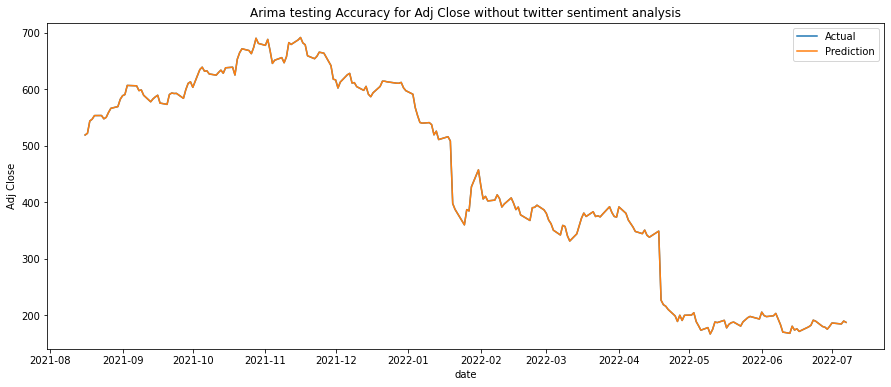

Testing absolute mean square error for Adj Close feature without twitter sentiment analysis 1.0145387129955273e-20


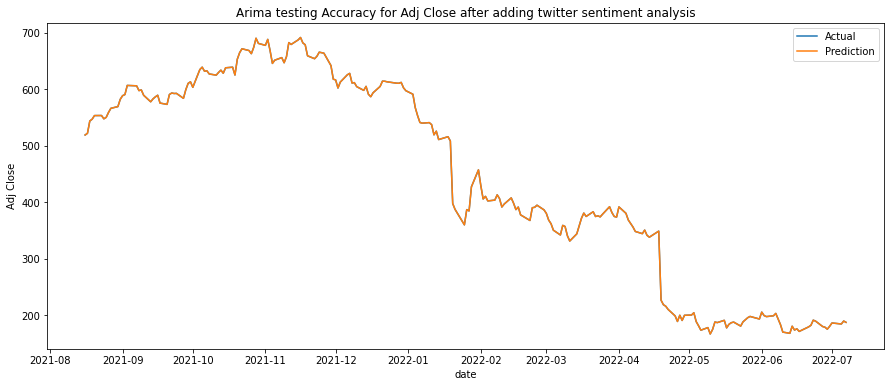

Testing absolute mean square error for Adj Close  feature with twitter sentiment analysis 1.0938434385844854e-20


In [33]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
test_prediction_without_twitter= arima_model_for_Adj_Close_without_twitter.predict(n_periods=len(X_test_arima_without_twitter), exogenous=X_test_arima_without_twitter)
test_prediction_twitter= arima_model_for_Adj_Close_twitter.predict(n_periods=len(X_test_arima_twitter), exogenous=X_test_arima_twitter)
plt.figure(figsize=(15,6))
sns.lineplot(x=y_test_arima['Adj Close'].index, y=y_test_arima['Adj Close'], label='Actual')
sns.lineplot(x=y_test_arima['Adj Close'].index, y=test_prediction_without_twitter, label='Prediction')
plt.title('Arima testing Accuracy for Adj Close without twitter sentiment analysis')
plt.show()
e=mean_squared_error(test_prediction_without_twitter, y_test_arima['Adj Close'])
print(f'Testing absolute mean square error for Adj Close feature without twitter sentiment analysis {e}')
plt.figure(figsize=(15,6))
sns.lineplot(x=y_test_arima['Adj Close'].index, y=y_test_arima['Adj Close'], label='Actual')
sns.lineplot(x=y_test_arima['Adj Close'].index, y=test_prediction_twitter, label='Prediction')
plt.title('Arima testing Accuracy for Adj Close after adding twitter sentiment analysis')
plt.show()
e=mean_squared_error(test_prediction_twitter, y_test_arima['Adj Close'])
print(f'Testing absolute mean square error for Adj Close  feature with twitter sentiment analysis {e}')


In [34]:
test_prediction_twitter

array([518.909973, 521.869995, 543.710022, 546.880005, 553.330017,
       553.409973, 547.580017, 550.119995, 558.919983, 566.179993,
       569.190002, 582.070007, 588.549988, 590.530029, 606.710022,
       606.049988, 597.539978, 598.719971, 589.289978, 577.76001 ,
       582.869995, 586.5     , 589.349976, 575.429993, 573.140015,
       590.650024, 593.26001 , 592.390015, 592.640015, 583.849976,
       599.059998, 610.340027, 613.150024, 603.349976, 634.809998,
       639.099976, 631.849976, 632.659973, 627.039978, 624.940002,
       629.76001 , 633.799988, 628.289978, 637.969971, 639.      ,
       625.140015, 653.159973, 664.780029, 671.659973, 668.52002 ,
       662.919983, 674.049988, 690.309998, 681.169983, 677.719971,
       688.289978, 668.400024, 645.719971, 651.450012, 655.98999 ,
       646.909973, 657.580017, 682.609985, 679.330017, 687.400024,
       691.690002, 682.02002 , 678.799988, 659.200012, 654.059998,
       658.289978, 665.640015, 663.840027, 641.900024, 617.770

# Forcasting for upcoming data

In [35]:
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past_dates = 5
n_days_for_prediction = 5 #let us predict past 15 days

predict_period_dates = pd.date_range(list(df_for_training.index)[-n_past_dates], periods=n_days_for_prediction,
                                     freq=us_bd).tolist()
print(predict_period_dates)

[Timestamp('2022-07-01 00:00:00', freq='C'), Timestamp('2022-07-05 00:00:00', freq='C'), Timestamp('2022-07-06 00:00:00', freq='C'), Timestamp('2022-07-07 00:00:00', freq='C'), Timestamp('2022-07-08 00:00:00', freq='C')]


In [36]:
features= ['Open','High', 'Low','Close','Volume','Adj Close','P_mean']
df_for_training.iloc[-n_past:,:].to_numpy().reshape(1,n_past,len(features)).shape

(1, 5, 7)

## Make forcasting using LSTM

In [37]:
x_forcast=df_for_training.iloc[-n_past-1:-1,:]
x_forcast=scaler.transform(x_forcast).reshape(1,n_past,len(features))
prediction = cnn_lstm_model_twitter.predict(x_forcast) #shape = (n, 1) where n is the n_days_for_prediction
prediction=prediction.reshape(prediction.shape[0],prediction.shape[2])
#Perform inverse transformation to rescale back to original range
prediction=scaler_for_inference.inverse_transform(prediction)

# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

print(f'Date = {forecast_dates[-2]}, Prediction open {prediction[0][0]}')
print(f'Date = {forecast_dates[-2]}, Prediction Adjusted close {prediction[0][1]}')

Date = 2022-07-07, Prediction open 189.40206909179688
Date = 2022-07-07, Prediction Adjusted close 190.13650512695312


### Actual forcasting in 2022-07-07 are  open 184.27     adjusted close 189.27

## Forcasting for upcoming data using Arima

In [38]:
x_forcast=X_arima[X_arima.index =='2022-07-07']
x_forcast

,High,Low,Close,Volume,P_mean,Adj Close_feature,open_feature_feature
date,,,,,,,
2022-07-07,190.210007,183.5,189.270004,6334500.0,-0.055427,186.979996,186.020004


In [39]:
x_forcast=X_arima[X_arima.index =='2022-07-07']
open_prediction = arima_model_for_open_twitter.predict(n_periods=len(x_forcast), exogenous=x_forcast)
adj_close_prediction = arima_model_for_Adj_Close_twitter.predict(n_periods=len(x_forcast),exogenous=x_forcast)#shape = (n, 1) where n is the n_days_for_prediction
# open_prediction=float(open_prediction)
# adj_close_prediction=float(adj_close_prediction)
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

print(f'Date = {forecast_dates[-2]}, Prediction open {open_prediction[0]}')
print(f'Date = {forecast_dates[-2]}, Prediction Adjusted close {adj_close_prediction[0]}')

Date = 2022-07-07, Prediction open 186.0200039996381
Date = 2022-07-07, Prediction Adjusted close 186.97999600003504


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


### Actual for 2022-07-07  forcasting  open 184.27     adjusted close 189.27